# SWDB - Day 2, Tutorial 2

## Population-Level Decoding: Part 2

In this tutorial, we will recap methods for accessing the Allen Brain Observatory Neuropixels dataset. We then look at the impact of correlated activity on stimulus decoding. Neurons do not exist in isolation, and it's important to consider how stimulus classification is affected when we account for redundancies in the population code.

First, let's import the packages we'll need:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

import warnings
warnings.filterwarnings("ignore")

Since we're analyzing data in the cloud, the public S3 bucket containing all of the data files is already mounted. So we just need to make sure the `EcephysProjectCache` object is aware of the location where the data is stored:

In [2]:
manifest_path = '/data/allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json' 

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Now we can load the sessions table and unit metrics, and select the same session as last time:

In [3]:
sessions = cache.get_session_table()

unit_metrics = cache.get_unit_analysis_metrics_by_session_type('brain_observatory_1.1')

unique_sessions = unit_metrics.ecephys_session_id.unique()
session_id = unique_sessions[10]

session = cache.get_session_data(session_id)

Let's load our units and stimulus presentations tables:

In [4]:
units = session.units # can be slow -- needs to load all spike times
units_VISp = units[units.ecephys_structure_acronym == 'VISp']
unit_metrics_VISp = unit_metrics.loc[units_VISp.index.values]

from allensdk.brain_observatory.ecephys.stimulus_table import naming_utilities
naming_utilities.standardize_movie_numbers = lambda a : a
session.naming_utilities = naming_utilities
stimulus_presentations = session.stimulus_presentations

Now we can construct our matrix of normalized firing rates for all V1 units and all drifting gratings trials:

(0.0, 94.0)

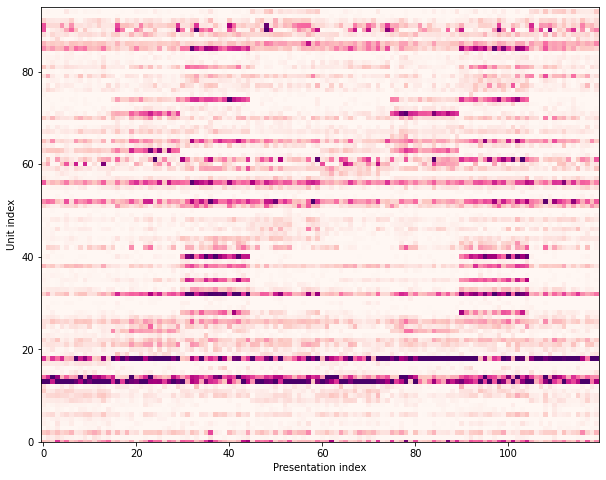

In [5]:
stimulus_presentations_dg = stimulus_presentations[stimulus_presentations.stimulus_name == 'drifting_gratings']

presentations = stimulus_presentations_dg[
            (stimulus_presentations_dg.temporal_frequency == 2.0)]

presentations = presentations.sort_values(by='orientation')
unit_ids = unit_metrics_VISp.sort_values(by=['pref_ori_dg']).index.values
        
da = session.presentationwise_spike_counts(np.arange(0,1.99,0.01), presentations.index.values, unit_ids)

plt.figure(figsize=(10,8))

firing_rates = da.sum('time_relative_to_stimulus_onset').T / 2
max_rates = firing_rates.max('unit_id')
norm_firing_rates = firing_rates / np.tile(max_rates, (len(unit_ids),1))

plt.imshow(norm_firing_rates, cmap='RdPu', aspect='auto', vmax=1)
plt.xlabel('Presentation index')
plt.ylabel('Unit index')
plt.ylim([0, len(unit_ids)])

Neurons are correlated with one another! E.g., look at units 35-40 and notice how they tend to have high activities, or low activities, on the same trials as one another.

The activities of correlated neural populations have a lower dimensionality than the number of neurons. E.g., for two perfectly correlated neurons, a single number suffices to describe both of their firing rates. This same idea applies to larger populations, and to less-than-perfect correlations.

To explore this property, we will apply the most common dimensionality reduction technique in existence to these data: Principal Component Analysis (PCA). This is a linear dimensionality reduction method (more on this later), and it works by considering the space of all possible neuron responses, wherein each axis of the space is a single neuron's firing rate. PCA finds the directions in this space along which the activities are the most spread out (highest variance) or the least spread out.

To see how this works, we'll consider the covariance matrix of the neuron activities. We'll then use an eigevalue decomposition to find the eigenvectors and eigenvalues of this matrix. Each eigenvector is called a Principal Component (PC) of the data, and each one represents a different direction in neural response space. The corresponding eigenvalues tell you the variance of the neural activities along that PC. The numpy linalg.eig function returns the eigenvectors (and eigenvalues) sorted in descending order by their corresponding eigenvalues.

For symmetric matrices (like covariance matrices) all the eigenvectors will be orthogonal, and for positive semi-definite matrices (like covariance matrices) all the eigenvalues will be greater than or equal to zero.

Text(0, 0.5, 'Eigenvalue (Variance along the n^th PC)')

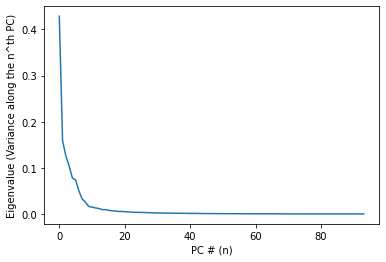

In [6]:
cov_mat = np.cov(norm_firing_rates)
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

plt.plot(eigenvalues)
plt.xlabel('PC # (n)')
plt.ylabel('Eigenvalue (Variance along the n^th PC)')

As you can see, the first ~20 eigenvalues are quite large (high variance), while the later ones are much smaller. We can see this more clearly by asking how much of the overall population activity is captured by the first n eigenvalues.

Text(0, 0.5, 'Fraction of Variance Explained')

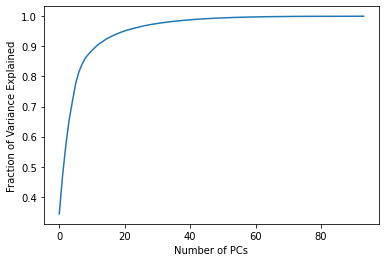

In [7]:
fraction_explained = np.cumsum(eigenvalues)/np.sum(eigenvalues)
plt.plot(fraction_explained)
plt.xlabel('Number of PCs')
plt.ylabel('Fraction of Variance Explained')

While the overall population has 94 neurons, we can capture ~90% of the variance in that population's activities with the first 12 principal components. Thus the 94-element vectors of neural population activity are ~12 dimensional: they can be well-described using only 12 descriptors. Geometrically, this fact tells us that the population activity vectors all lie near a 12-dimensional hyperplane within the (94-D) space of all possible neural activities.

Importantly PCA is a \bold{linear} method: the low-dimensional manifolds it finds are hyperplanes. This means that low-dimensional structure in neural population activities that lies along \bold{curved} manifolds may not be identified by PCA. For that reason, PCA-defined dimensionality is an \emph{upper bound} on the true dimensionality of the population activity: there could always be lower-dimensional structures with nonlinear properties that PCA just can't find.

There exist many beautiful methods for finding low-dimensional nonlinear structure in neural data (and other kinds of data), including Isomap, Local Linear Embedding (LLE), and deep neural network autoencoders with bottlenecks. These are much more finicky than PCA.

So far, we have look at the correlations between neurons without considering how much of those correlations are stimulus-driven (e.g., reflecting neurons with similar tuning responding to the same stimulus at the same time) vs correlations that arise from other sources. The correlations due to the stimulus properties are called \emph{signal correlations}, whereas correlations due to other sources (including random variability within the eyes and the brain) are called \emph{noise correlations}. The correlations we considered above encapsulate both of these factors, and are called \emph{total} correlations.

To separate these out, we'll now compute and compare all 3 (Pearson) correlation matrices: the total correlations, signal correlations, and noise correlations.

First, the total correlations.

Text(0, 0.5, 'Neuron ID')

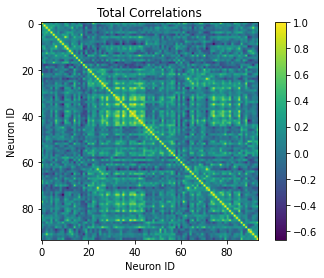

In [8]:
total_correlations = np.corrcoef(norm_firing_rates)
plt.imshow(total_correlations)
plt.colorbar()
plt.title('Total Correlations')
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')

Next, we'll compute the signal correlations. These are the correlations in the neurons' average response to each stimulus (defined by orientation), computed across stimuli. As the name implies, they tell us how much two neurons' mean (trial averaged) activities co-vary as the stimulus changes.

To compute these, we'll first calculate the average activities for each stimulus orientation and neuron, then compute the correlation matrix across stimuli.

Recall that each stimulus was presented 15 times, and we have ordered the stimuli by orientation.

Text(0, 0.5, 'Neuron ID')

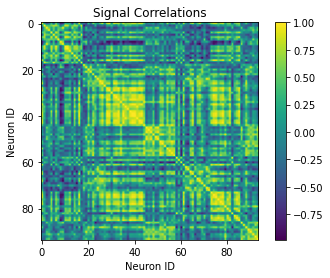

In [9]:
mean_resp = np.zeros([94,8]) #initialize our array of 94 neurons x 8 stimuli
for i in range(0,8):
    mean_resp[:,i] = np.mean(norm_firing_rates[:,i*15:i*15+15],axis=1)

signal_correlations = np.corrcoef(mean_resp)
plt.imshow(signal_correlations)
plt.colorbar()
plt.title('Signal Correlations')
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')

Finally, let's compute the noise correlations. These are the correlations in the responses to each stimulus, reflecting the (correlated) trial-to-trial variability in the neural population. These correlations are defined on a per-stimulus basis and can vary somewhat between stimuli. For sake of interest, we'll plot below the correlation matrices for two different stimuli, and we'll later make use of the average correlation matrix (averaged over all 8 orientations).

Text(0, 0.5, 'Neuron ID')

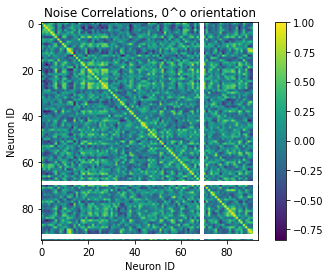

In [10]:
noise_correlations = np.zeros([94,94,8]) #initialize our array of correlation matrices for each stim
for i in range(0,8):
    noise_correlations[:,:,i] = np.corrcoef(norm_firing_rates[:,i*15:i*15+15])

plt.imshow(noise_correlations[:,:,0])
plt.colorbar()
plt.title('Noise Correlations, 0^o orientation')
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')

Text(0, 0.5, 'Neuron ID')

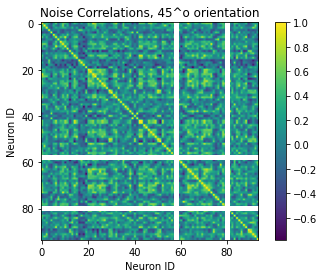

In [11]:
plt.imshow(noise_correlations[:,:,1])
plt.colorbar()
plt.title('Noise Correlations, 45^o orientation')
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')

Text(0, 0.5, 'Neuron ID')

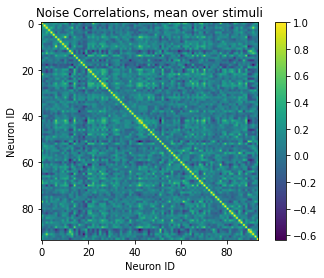

In [12]:
mean_noise_correlations = np.nanmean(noise_correlations,axis=2)
plt.imshow(mean_noise_correlations)
plt.colorbar()
plt.title('Noise Correlations, mean over stimuli')
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')

A few things to note. 

First, the correlation coefficient is undefined (NaN) for any stimulus where one of the neurons in the pair doesn't spike at all. Those show up as missing rows/columns of the correlation matrix. When we average over stimuli, we use nanmean for this reason. That function takes the mean over all the non-NaN values. Otherwise, many pairs of neurons have undefined mean correlations.

Second, notice that the noise correlations can vary a lot between stimuli: the same neuron pair can be ~strongly correlated for one stimuli and anti-correlated for another stimulus.

Third, notice that the mean noise correlations are relatively weak, whereas the signal correlations can be much stronger (we show this explicitly in the cell below). This is typical for cortical recordings, although different results and be obtained in other parts of the nervous system. E.g., in retina, at lower light levels, noise correlations can be quite strong.

Finally, we'll compare the noise and signal correlations.

Mean Noise Correlation:
0.06461000054718673
Mean Signal Correlation:
0.11974658991734327


Text(0, 0.5, 'Noise Correlation')

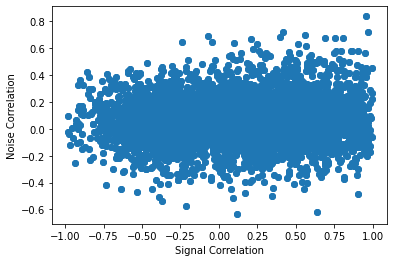

In [13]:
ncorr = np.matrix.flatten(mean_noise_correlations)
indices = np.where(ncorr > 0.99) #remove the ones along the diagonal
ncorr = np.delete(ncorr, indices)

print('Mean Noise Correlation:')
print(np.mean(ncorr))

scorr = np.matrix.flatten(signal_correlations)
scorr = np.delete(scorr,indices)

print('Mean Signal Correlation:')
print(np.mean(scorr))

plt.scatter(scorr,ncorr)
plt.xlabel('Signal Correlation')
plt.ylabel('Noise Correlation')

These look ~unrelated to each other! If we look closer, we'll note that there is a small (but statistically quite significant) trend for neuron pairs with higher signal correlation to have higher noise correlation, and vice versa.

For this, we'll use the scipy pearsonr function instead of numpy corrcoef, because it returns a p-value from the hypothesis test where the null hypothesis is zero correlation.

In [14]:
from scipy.stats.stats import pearsonr
pearsonr(ncorr,scorr)

PearsonRResult(statistic=0.08042854057843703, pvalue=5.031924396450127e-14)

While the relation is fairly weak, it is quite robust, and the existence of this positive relationship between signal and noise correlations rules out lots of computational models that made the opposite prediction. See, E.g., the local competition algorithm for implementing sparse coding, which was once a leading theory of V1 computation.

While the noise correlations are fairly weak (averaging ~0.06), it is worth asking whether or not -- from an information processing standpoint -- we can treat each neuron as independent. In other words, are the noise correlations weak enough that they can be ignored?

To test this, we'll return to the decoding analysis from Tutorial 1, and we will try decoding the stimulus in two ways. First, we will decode from the true neural data, which contains the (weak) noise correlations. This is the same as we did in Tutorial 1, so feel free to jump ahead.

In [15]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

responses = norm_firing_rates.data.T
labels = presentations.orientation.values.astype('int')
conditions = np.unique(labels)

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = svm.SVC(gamma="scale", kernel="linear")
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

0.6666666666666667
0.875
0.7083333333333333
0.75
0.7083333333333333

mean accuracy: 0.7416666666666666
chance: 0.125


Next, for comparison, we will try decoding from synthetic data in which we artificially remove the noise correlations. We do this by trial-shuffling the neural data. This creates a fake dataset in which non-simultaneously-recorded neural activities are assembled to make the population response vectors, and it removes the noise correlations.

To do this, we go through the data, and for each stimulus, and for each neuron, we randomly (and independently) re-order the trials.

In [16]:
shuff_dat = np.zeros([94,120]) #initialize our array of 94 neurons x 120 trials
for i in range(0,8): #loop over all stimuli
    for neur in range(0,94): #loop over all neurons
        shuffled_indices = np.random.permutation(15)    
        shuff_dat[neur,i*15:i*15+15] = norm_firing_rates[neur,i*15 + shuffled_indices]                                                

As a quick check, we'll compute the noise correlations on the suffled data and check that they are indeed nearly zero. (Note: if you re-run the shuffle procedure in the above cell, and then re-run the noise correlation calculation below, you should get a slightly different, small mean noise correlation each time. These differences represent the randomness of the shuffling procedure).

In [17]:
shuff_noise_correlations = np.zeros([94,94,8]) #initialize our array of correlation matrices for each stim
for i in range(0,8):
    shuff_noise_correlations[:,:,i] = np.corrcoef(shuff_dat[:,i*15:i*15+15])

shuff_mean_noise_correlations = np.nanmean(shuff_noise_correlations,axis=2)

shuff_ncorr = np.matrix.flatten(shuff_mean_noise_correlations)
indices = np.where(shuff_ncorr > 0.99) #remove the ones along the diagonal
shuff_ncorr = np.delete(shuff_ncorr, indices)

print('Mean Shuff Noise Correlation:')
print(np.mean(shuff_ncorr))

Mean Shuff Noise Correlation:
0.0008214503438837873


The noise correlations in the shuffled data are indeed near zero (as expected). We can also check that the signal correlations are unaffected by the shuffle procedure:

In [18]:
mean_resp = np.zeros([94,8]) #initialize our array of 94 neurons x 8 stimuli
for i in range(0,8):
    mean_resp[:,i] = np.mean(shuff_dat[:,i*15:i*15+15],axis=1)

shuff_signal_correlations = np.corrcoef(mean_resp)
shuff_scorr = np.matrix.flatten(shuff_signal_correlations)
shuff_scorr = np.delete(shuff_scorr,indices)

print('Mean Shuff Signal Correlation:')
print(np.mean(shuff_scorr))



Mean Shuff Signal Correlation:
0.11974658991734327


Finally, let's see how removing the noise correlations affected the decodability:

In [19]:
responses = shuff_dat
labels = presentations.orientation.values.astype('int')
conditions = np.unique(labels)

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = svm.SVC(gamma="scale", kernel="linear")
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

0.21052631578947367
0.26315789473684215
0.368421052631579
0.052631578947368474
0.11111111111111116

mean accuracy: 0.2011695906432749
chance: 0.125


Even though they were weak, removing the noise correlations strongly reduced the decoding accuracy. In other circumstances, removing noise correlations can increase decoding performance: the effects depend sensitively on the structure of the signal and noise correlations, and this has been the topic of a lot of study!


Problem Sets:

1) Study the dimensionality of the trial shuffled population activities. How much of the low-dimensionality can be attributed to signal correlations vs noise correlations?

2) How is decoding of different stimulus attributes affected by noise correlation? (E.g., natural scenes, etc.)

3) How much does the dependence of decoding on noise correlations vary between brain regions or cortical depths?

4) How are noise correlations affected by behavioral state? E.g., how much of that correlation is driven by neurons responding similarly to global behahvioral changes, vs other variables?

5) How much do the signal and noise correlations vary between brain areas or cortical depths?